In [ ]:
!pip install transformers datasets sentencepiece rouge-score evaluate accelerate


  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached sentencepiece-0.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (10 kB)
  Using cached rouge_score-0.1.2-py3-none-any.whl
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.4 kB)
  Using cached regex-2025.11.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (40 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached safetensors-0.7.0-cp38-abi3-macosx_11_0_arm64.whl.metadata (4.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-macosx_11_0_arm64.whl.metadata (4.9 kB)
  Using cached pyarrow-22.0.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (3.2 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.met

In [ ]:
!pip install scikit-learn


  Using cached scikit_learn-1.8.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.8.0-cp313-cp313-macosx_12_0_arm64.whl (8.0 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-learn] [scikit-learn]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split

# Data

## Data Loading

In [ ]:
df = pd.read_csv("/content/samsum_train.csv")
test = pd.read_csv("/content/samsum_test.csv")
sample = pd.read_csv("/content/sample_submission.csv")

In [ ]:
print("Train",df.shape)
print("Test",test.shape)


Train (10312, 3)
Test (2210, 2)


In [ ]:
print("===== Columns =====")
print(df.columns)

print("\n===== Basic Info =====")
print(df.info())

print("\n===== Null Values =====")
print(df.isnull().sum())

===== Columns =====
Index(['id', 'dialogue', 'summary'], dtype='object')

===== Basic Info =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10312 entries, 0 to 10311
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10312 non-null  object
 1   dialogue  10311 non-null  object
 2   summary   10312 non-null  object
dtypes: object(3)
memory usage: 241.8+ KB
None

===== Null Values =====
id          0
dialogue    1
summary     0
dtype: int64


In [ ]:
print("\n===== Sample Rows =====")
item = df.sample(1, random_state=40)

print("Dialogue")
print(item.dialogue)

print("Summary")
print(item.summary)


===== Sample Rows =====
Dialogue
10280    John: Are you home?\r\nAnn: yes, in bed\r\nJoh...
Name: dialogue, dtype: object
Summary
10280    A is at home in bed.
Name: summary, dtype: object


### Computer Word Length

In [ ]:
df["dialogue_len_words"] = df["dialogue"].astype(str).apply(lambda x: len(x.split()))
df["summary_len_words"]  = df["summary"].astype(str).apply(lambda x: len(x.split()))

print("\n===== Dialogue Length (Characters) =====")
print(df["dialogue_len_char"].describe())

print("\n===== Summary Length (Characters) =====")
print(df["summary_len_char"].describe())


===== Dialogue Length (Characters) =====
count    10312.000000
mean       510.079713
std        403.216424
min          3.000000
25%        218.000000
50%        397.000000
75%        692.000000
max       5492.000000
Name: dialogue_len_char, dtype: float64

===== Summary Length (Characters) =====
count    10312.000000
mean       101.256788
std         58.488346
min          4.000000
25%         56.000000
50%         88.000000
75%        134.000000
max        300.000000
Name: summary_len_char, dtype: float64


### Compute character Lengths


In [ ]:
df["dialogue_len_char"] = df["dialogue"].astype(str).apply(len)
df["summary_len_char"]  = df["summary"].astype(str).apply(len)


print("\n===== Dialogue Length (Words) =====")
print(df["dialogue_len_words"].describe())

print("\n===== Summary Length (Words) =====")
print(df["summary_len_words"].describe())





===== Dialogue Length (Words) =====
count    10312.000000
mean        93.599884
std         74.067218
min          1.000000
25%         40.000000
50%         73.000000
75%        127.000000
max        638.000000
Name: dialogue_len_words, dtype: float64

===== Summary Length (Words) =====
count    10312.000000
mean        20.385279
std         11.235380
min          1.000000
25%         12.000000
50%         18.000000
75%         27.000000
max         60.000000
Name: summary_len_words, dtype: float64


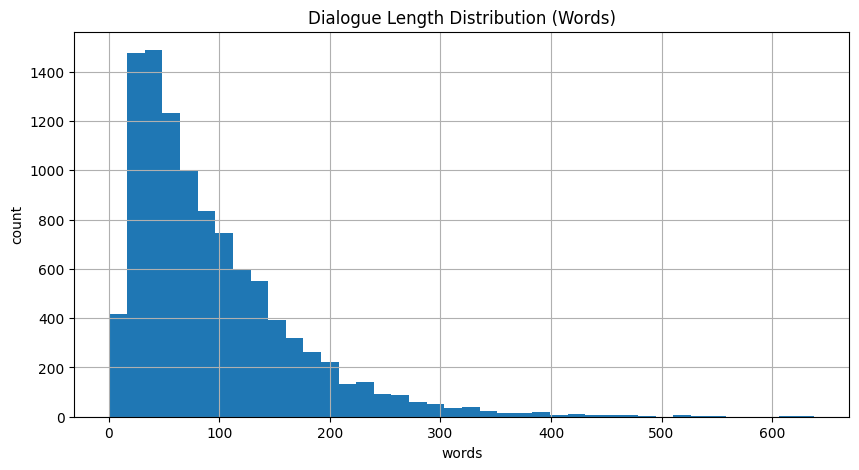

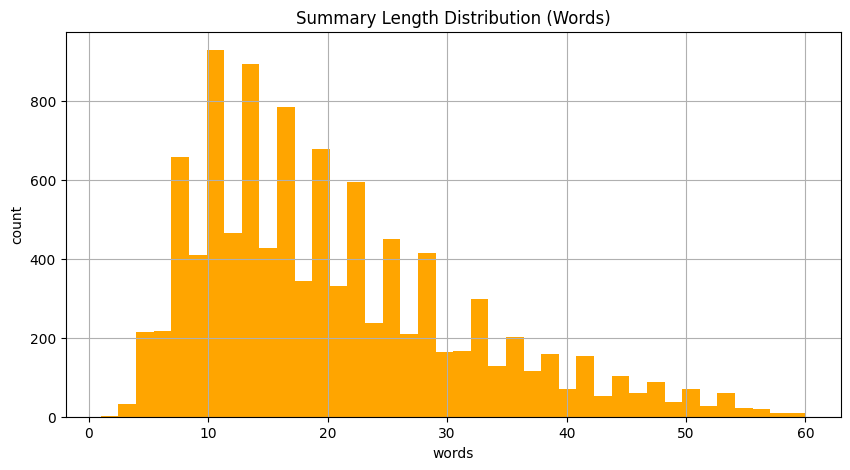

In [ ]:
plt.figure(figsize=(10,5))
df["dialogue_len_words"].hist(bins=40)
plt.title("Dialogue Length Distribution (Words)")
plt.xlabel("words")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(10,5))
df["summary_len_words"].hist(bins=40, color='orange')
plt.title("Summary Length Distribution (Words)")
plt.xlabel("words")
plt.ylabel("count")
plt.show()


## Noise

In [ ]:
def check_noise(text):
    if not isinstance(text, str):
        return False
    noise_keywords = ["http", "www", "AM", "PM", "timestamp"]
    text = text.lower()
    return any(k.lower() in text for k in noise_keywords)

df["dialogue"] = df["dialogue"].fillna("")
df["has_noise"] = df["dialogue"].apply(check_noise)

print("\nNoise present in dialogues:", df["has_noise"].mean()*100, "%")



Noise present in dialogues: 45.50038789759503 %


In [ ]:
import re
import pandas as pd

def clean_dialogue(text):
    if not isinstance(text, str):
        return text

    text = text.strip()

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove timestamps like 10:30 PM / 5:00 am / 23:59
    text = re.sub(r'\b\d{1,2}:\d{2}\s?(AM|PM|am|pm)?\b', '', text)

    # Remove long emoji chains (but allow occasional emoji)
    text = re.sub(r'([\U00010000-\U0010ffff]{2,})', '', text)

    # Remove repeated punctuation e.g. !!!!! or ????
    text = re.sub(r'([!?.,])\1{2,}', r'\1', text)

    # Collapse excessive whitespace
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

# Apply to dataset

df["dialogue"] = df["dialogue"].apply(clean_dialogue)
print("Cleaning Done")
print(df.head())


Cleaning Done
         id                                           dialogue  \
0  13818399  Max: How's your job hunt going? Dorothy: Uhh, ...   
1  13865364  Jim: We should meet at the cathedral church Ti...   
2  13682301  Maryann: How long do I cook rice? Howard: What...   
3  13730492  Eric: Wya? Eve: College Green Eric: stay there...   
4  13728552  Ethan: Wanna play basketball tomorrow? Logan: ...   

                                             summary  dialogue_len_words  \
0  B has been looking for a job and sending a hun...                  72   
1  A, Tim and Margaret will meet at the cathedral...                  23   
2  It takes up to 25 minutes to cook brown rice a...                 147   
3                  B will pick A from College Green.                  14   
4  A and B will play basketball tomorrow. A has a...                  19   

   summary_len_words  dialogue_len_char  summary_len_char  has_noise  
0                 28                352               136    

In [ ]:
def check_noise(text):
    if not isinstance(text, str):
        return False
    noise_keywords = ["http", "www", "AM", "PM", "timestamp"]
    text = text.lower()
    return any(k.lower() in text for k in noise_keywords)

df["dialogue"] = df["dialogue"].fillna("")
df["has_noise"] = df["dialogue"].apply(check_noise)

print("\nNoise after cleaning in dialogues:", df["has_noise"].mean()*100, "%")



Noise after cleaning in dialogues: 45.180372381691235 %


In [ ]:
import re

def count_speakers(dialog):
    speakers = re.findall(r"[A-Za-z0-9_]+:", dialog)
    return len(set(speakers))

df["unique_speakers"] = df["dialogue"].apply(count_speakers)

print("\n===== Unique Speakers Stats =====")
print(df["unique_speakers"].describe())
print(df["unique_speakers"].value_counts().head())



===== Unique Speakers Stats =====
count    10312.000000
mean         2.458980
std          0.895719
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: unique_speakers, dtype: float64
unique_speakers
2    7155
3    2155
4     667
5     189
6      71
Name: count, dtype: int64


### Hyperparameter
for T5
*   max_input_length  = 512
*  max_target_length = 80

Reason:
* 75% dialogue fit well under 512 tokens
* summaries never exceed 80 meaningful tokens





# T5 Training + Evaluation Pipeline

In [ ]:
df = pd.read_csv("samsum_train_cleaned.csv")
test  = pd.read_csv("samsum_test_cleaned.csv")

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Train DataFrame shape: {train_df.shape}")
print(f"Validation DataFrame shape: {val_df.shape}")

Train DataFrame shape: (6522, 2)
Validation DataFrame shape: (1631, 2)


In [ ]:
train_df.head()

,dialogue,summary
293,"Nina: Hey guys, are you available for a call t...","B, C and A will talk about the landlord troubl..."
6702,Ceil: help with French pls!\nDarton: can't hel...,A needs help with French and Keyton sends her ...
4764,Polly: You making something for Friday?\nKelly...,A plans to make Rocky Road for Friday. B is do...
5790,Michael: hey did Kate read this book?\nMichael...,Jessie and Scarlett think Kate would like to r...
6701,"Jenny: has anybody seen my wallet?\nKate: yes,...",B found A's wallet and brought it to the welco...


In [ ]:
import os
os.environ.pop("WANDB_DISABLED", None)
os.environ["WANDB_MODE"] = "online"

In [ ]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login(key="ef37eebb820e6f1d80a7be280903546f0e4773be")

True

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
import evaluate
import torch


# -----------------------------------------
# Load your cleaned train + val
# -----------------------------------------
train_df = train_df[["dialogue", "summary"]]
val_df = val_df[["dialogue", "summary"]]

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})

In [ ]:
 #-----------------------------------------
# Model + Tokenizer
# -----------------------------------------
model_name = "t5-base"  # Use "t5-small" for 3x faster training
tokenizer = T5TokenizerFast.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Enable gradient checkpointing to save memory and allow larger batches
model.gradient_checkpointing_enable()

max_input_length = 512
max_target_length = 80

# -----------------------------------------
# Preprocess Function (OPTIMIZED)
# -----------------------------------------
def preprocess(batch):
    inputs = ["summarize: " + d for d in batch["dialogue"]]

    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["summary"],
            max_length=max_target_length,
            truncation=True,
            padding="max_length",
        )

    # IMPORTANT: ignore padding tokens in loss
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in seq]
        for seq in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Process with more workers for faster data loading
tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset["train"].column_names,
    num_proc=4  # Use multiple processes
)

# -----------------------------------------
# Metric (OPTIMIZED - Only compute on smaller sample)
# -----------------------------------------
try:
    rouge = evaluate.load("rouge")
    print("Successfully loaded ROUGE from evaluate library")
except Exception as e:
    print(f"Error loading rouge from evaluate: {e}")
    print("Using rouge_score directly instead...")
    from rouge_score import rouge_scorer
    rouge = None

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(
        preds, skip_special_tokens=True
    )

    labels = [
        [t for t in label if t != -100]
        for label in labels
    ]
    decoded_labels = tokenizer.batch_decode(
        labels, skip_special_tokens=True
    )

    if rouge is not None:
        try:
            return rouge.compute(
                predictions=decoded_preds,
                references=decoded_labels,
                use_stemmer=True
            )
        except:
            pass
    
    # Fallback to rouge_score if evaluate.load failed
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for pred, ref in zip(decoded_preds, decoded_labels):
        score = scorer.score(ref, pred)
        rouge1_scores.append(score['rouge1'].fmeasure)
        rouge2_scores.append(score['rouge2'].fmeasure)
        rougeL_scores.append(score['rougeL'].fmeasure)
    
    return {
        'rouge1': sum(rouge1_scores) / len(rouge1_scores),
        'rouge2': sum(rouge2_scores) / len(rouge2_scores),
        'rougeL': sum(rougeL_scores) / len(rougeL_scores),
    }

# -----------------------------------------
# Data Collator
# -----------------------------------------
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
)

# -----------------------------------------
# Training Arguments (OPTIMIZED FOR SPEED)
# -----------------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-base-dialogue-sum",
    
    # SPEED OPTIMIZATIONS:
    # Increase batch size significantly (was 1, now 4-8 depending on GPU memory)
    per_device_train_batch_size=4,      # Increase from 1 to 4 (4x faster)
    per_device_eval_batch_size=4,       # Increase from 1 to 4
    gradient_accumulation_steps=4,      # Reduce from 8 to 4 (effective batch = 16)
    
    # Evaluate less frequently to save time
    eval_strategy="steps",
    eval_steps=2000,                     # Increased from 1000 (eval takes time)
    logging_steps=100,                   # Reduced from 200 for more frequent updates
    save_steps=2000,                     # Increased from 1000
    save_total_limit=1,                  # Keep only 1 checkpoint to save disk space
    
    # Training settings
    learning_rate=3e-4,
    num_train_epochs=3,
    warmup_ratio=0.1,
    weight_decay=0.01,
    
    # Performance optimizations
    fp16=True,                           # Already enabled
    dataloader_num_workers=2,            # Use multiple workers for data loading
    dataloader_pin_memory=True,          # Pin memory for faster GPU transfer
    gradient_checkpointing=True,         # Save memory, allow larger batches
    
    # Generation settings
    predict_with_generate=True,
    generation_max_length=80,
    
    # Disable wandb for speed
    report_to="none",
    
    # Additional speed optimizations
    logging_first_step=True,
    load_best_model_at_end=False,       # Skip loading best model to save time
)

# -----------------------------------------
# Trainer (OPTIMIZED)
# -----------------------------------------
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Starting training with optimizations...")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Total training steps: ~{len(tokenized_dataset['train']) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) * training_args.num_train_epochs}")
trainer.train()
print("Training completed!")

In [ ]:
# -----------------------------------------
# Model + Tokenizer (A100 OPTIMIZED)
# -----------------------------------------
model_name = "t5-base"  # Can also try "t5-large" on A100
tokenizer = T5TokenizerFast.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Move model to GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

max_input_length = 512
max_target_length = 80

# -----------------------------------------
# Preprocess Function
# -----------------------------------------
def preprocess(batch):
    inputs = ["summarize: " + d for d in batch["dialogue"]]

    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["summary"],
            max_length=max_target_length,
            truncation=True,
            padding="max_length",
        )

    # IMPORTANT: ignore padding tokens in loss
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in seq]
        for seq in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Process with multiple workers for faster data loading
print("Tokenizing datasets...")
tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset["train"].column_names,
    num_proc=4
)
print("Tokenization complete!")

# -----------------------------------------
# Metric
# -----------------------------------------
try:
    rouge = evaluate.load("rouge")
    print("Successfully loaded ROUGE from evaluate library")
except Exception as e:
    print(f"Error loading rouge from evaluate: {e}")
    print("Using rouge_score directly instead...")
    from rouge_score import rouge_scorer
    rouge = None

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(
        preds, skip_special_tokens=True
    )

    labels = [
        [t for t in label if t != -100]
        for label in labels
    ]
    decoded_labels = tokenizer.batch_decode(
        labels, skip_special_tokens=True
    )

    if rouge is not None:
        try:
            return rouge.compute(
                predictions=decoded_preds,
                references=decoded_labels,
                use_stemmer=True
            )
        except:
            pass
    
    # Fallback to rouge_score
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for pred, ref in zip(decoded_preds, decoded_labels):
        score = scorer.score(ref, pred)
        rouge1_scores.append(score['rouge1'].fmeasure)
        rouge2_scores.append(score['rouge2'].fmeasure)
        rougeL_scores.append(score['rougeL'].fmeasure)
    
    return {
        'rouge1': sum(rouge1_scores) / len(rouge1_scores),
        'rouge2': sum(rouge2_scores) / len(rouge2_scores),
        'rougeL': sum(rougeL_scores) / len(rougeL_scores),
    }

# -----------------------------------------
# Data Collator
# -----------------------------------------
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
)

# -----------------------------------------
# Training Arguments (A100 OPTIMIZED - MAXIMUM PERFORMANCE)
# -----------------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-base-dialogue-sum",
    
    # A100 OPTIMIZATIONS - AGGRESSIVE BATCH SIZES
    per_device_train_batch_size=16,      # A100 can handle this easily
    per_device_eval_batch_size=16,       # Larger eval batch
    gradient_accumulation_steps=2,       # Effective batch = 32
    
    # Evaluation and logging
    eval_strategy="steps",
    eval_steps=500,                      # More frequent eval on A100
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    
    # Training settings
    learning_rate=3e-4,
    num_train_epochs=3,
    warmup_steps=500,
    weight_decay=0.01,
    
    # A100-specific optimizations
    bf16=True,                           # A100 has better bfloat16 support than fp16
    dataloader_num_workers=4,            # More workers for A100
    dataloader_pin_memory=True,
    gradient_checkpointing=False,        # A100 has enough memory, disable for speed
    
    # Generation settings
    predict_with_generate=True,
    generation_max_length=80,
    generation_num_beams=4,              # Better quality predictions
    
    # Performance
    report_to="none",
    logging_first_step=True,
    load_best_model_at_end=True,         # Load best model for inference
    metric_for_best_model="rougeL",
    greater_is_better=True,
    
    # Additional A100 optimizations
    optim="adamw_torch_fused",           # Faster optimizer on A100
    group_by_length=True,                # Group similar lengths for efficiency
    ddp_find_unused_parameters=False,
)

# -----------------------------------------
# Trainer
# -----------------------------------------
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# -----------------------------------------
# TRAINING
# -----------------------------------------
print("="*80)
print("Starting training with A100 optimizations...")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Total training samples: {len(tokenized_dataset['train'])}")
print(f"Total validation samples: {len(tokenized_dataset['validation'])}")
print("="*80)

trainer.train()
print("\n" + "="*80)
print("Training completed!")
print("="*80)

# -----------------------------------------
# Save the best model
# -----------------------------------------
print("\nSaving best model...")
trainer.save_model("./t5-best-model")
tokenizer.save_pretrained("./t5-best-model")
print("Model saved to ./t5-best-model")

In [ ]:
# -----------------------------------------
# INFERENCE ON TEST SET & SUBMISSION GENERATION
# -----------------------------------------
print("="*80)
print("Starting inference on test set...")
print("="*80)

# Load the best model
from transformers import T5ForConditionalGeneration, T5TokenizerFast
import torch
from tqdm import tqdm

model_path = "./t5-best-model"
tokenizer = T5TokenizerFast.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print(f"Model loaded from {model_path}")
print(f"Device: {device}")

# Prepare test data
test_dialogues = test["dialogue"].fillna("").tolist()
test_ids = test["id"].tolist()

print(f"\nTotal test samples: {len(test_dialogues)}")

# Generate predictions in batches
batch_size = 32  # A100 can handle large batches
predictions = []

print("\nGenerating predictions...")
for i in tqdm(range(0, len(test_dialogues), batch_size)):
    batch_dialogues = test_dialogues[i:i+batch_size]
    
    # Preprocess
    inputs = ["summarize: " + d for d in batch_dialogues]
    
    # Tokenize
    tokenized = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding=True,
        return_tensors="pt"
    ).to(device)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **tokenized,
            max_length=80,
            num_beams=4,              # Use beam search for better quality
            length_penalty=0.6,
            early_stopping=True,
            no_repeat_ngram_size=3,   # Avoid repetition
        )
    
    # Decode
    batch_predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    predictions.extend(batch_predictions)

print(f"\nGenerated {len(predictions)} predictions")

# -----------------------------------------
# Create submission.csv
# -----------------------------------------
import pandas as pd

submission_df = pd.DataFrame({
    'id': test_ids,
    'summary': predictions
})

# Save submission file
submission_df.to_csv('submission.csv', index=False)

print("\n" + "="*80)
print("Submission file created successfully!")
print("="*80)
print(f"\nSubmission shape: {submission_df.shape}")
print(f"Saved to: submission.csv")

# Display first few predictions
print("\n" + "="*80)
print("Sample predictions:")
print("="*80)
for i in range(min(5, len(submission_df))):
    print(f"\n--- Sample {i+1} ---")
    print(f"ID: {submission_df.iloc[i]['id']}")
    print(f"Dialogue: {test_dialogues[i][:200]}...")
    print(f"Predicted Summary: {submission_df.iloc[i]['summary']}")
    print()

# Verify submission format
print("="*80)
print("Submission file verification:")
print("="*80)
print(submission_df.head(10))
print("\nSubmission file is ready for upload!")